In [1]:
!rm jjas40.nc
!rm Percentilejjas.nc
!rm Percentilejjas2.nc

In [2]:
import cdo
import xarray as xr
import numpy as np
import matplotlib as plt

In [3]:
!cdo -select,season=JJAS sst.day.mean.2021.nc jjas40.nc

cdo select: Processed 126489600 values from 1 variable over 365 timesteps [2.57s 129MB]


In [4]:
sst=xr.open_dataset("/home/matin/project/major/code/verification/jjas40.nc")
sst_40=sst.sst

In [5]:
!cdo -select,season=JJAS percentile40.nc Percentilejjas.nc

cdo select: Processed 2440000 values from 1 variable over 365 timesteps [0.04s 130MB]


In [6]:
Prcntl_jjas= xr.open_dataset("/home/matin/project/major/code/verification/Percentilejjas.nc")
ds=Prcntl_jjas.assign_coords({'time':Prcntl_jjas.time.dt.dayofyear})
ds.to_netcdf("Percentilejjas2.nc")

Prcntl_jjas2= xr.open_dataset("/home/matin/project/major/code/verification/Percentilejjas2.nc")

In [7]:
dataset=sst_40.assign_coords({'time':Prcntl_jjas.time.dt.dayofyear})
dataset.to_netcdf("dataset.nc")

In [8]:
dataset2=dataset.sel(lon=slice(50,100),lat=slice(0,25))
dataset2.to_netcdf("dataset2.nc")

In [9]:
!rm change.nc
!rm logic.nc
!cdo -s sub dataset2.nc Percentilejjas2.nc change.nc  
!cdo -s gt dataset2.nc Percentilejjas2.nc logic.nc 

Warning (splitTimevalue): Reset wrong date/time to 0000-01-01 00:00:00!
Warning (splitTimevalue): Reset wrong date/time to 0000-01-01 00:00:00!


In [10]:
change=xr.open_dataset("/home/matin/project/major/code/verification/change.nc")
change=change.assign_coords({'time':Prcntl_jjas.time.dt.dayofyear})
ch=change.sst[4:]

In [11]:
logic=xr.open_dataset("/home/matin/project/major/code/verification/logic.nc")
logic=logic.assign_coords({'time':Prcntl_jjas.time.dt.dayofyear})
lo=logic.sst[4:]

In [12]:

l=[]
for i in range(0,118):
    five_days=logic.sst[i:i+5].sum('time',skipna=False)
    l.append(xr.where(five_days<5,0,five_days).data)
fivexr6=xr.DataArray(np.array(l), coords=[("time",logic.time.data[4:]),("lat", logic.lat.data), ("lon", logic.lon.data)])

fivexr61=xr.where(fivexr6==5,1,fivexr6)


m=[]
for i in range(0,118):
    a=fivexr61[i:i+2].sum("time",skipna=False)
    m.append(xr.where(a>1,0,a).data)
fivexr62=xr.DataArray(np.array(m), coords=[("time",logic.time.data[4:]),("lat", logic.lat.data), ("lon", logic.lon.data)])


frqyr21=fivexr62.sum("time",skipna=False)
iyr21=xr.where(fivexr61==1,ch,fivexr61).sum("time",skipna=False)


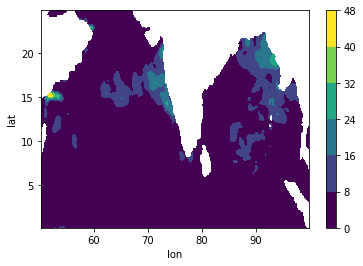

In [13]:
intensity=xr.where(fivexr61==1,ch,fivexr61).sum("time",skipna=False)
intensity.plot.contourf()

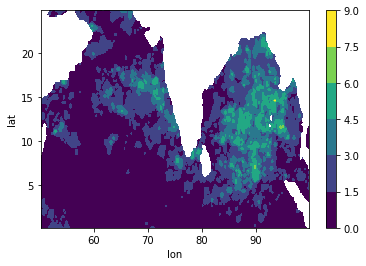

In [17]:
frequency=xr.where(frqyr21%2==0,frqyr21//2,(frqyr21+1)/2)
frequency.plot.contourf()

In [18]:
frequency.where(frequency==frequency.max(), drop=True).squeeze()

<xarray.DataArray ()>
array(8., dtype=float32)
Coordinates:
    lat      float32 14.62
    lon      float32 93.62

In [20]:
dataset=xr.open_dataset("sst.day.mean.2021.nc")
percentile90=xr.open_dataset("percentile40.nc")

In [22]:
import pandas as pd

In [25]:
##Converting Xarray Data into DataFrames and Concatening them
dataset2=dataset.sel(lon=slice(50,100),lat=slice(0,25))
rolling_mean=percentile90.rolling(time=11).mean()
SST=pd.DataFrame(dataset2.sst[:,58,174].astype(np.float32).data,index=pd.date_range("2021-01-01", periods=365),columns=['SST'])
NiNtypercentile=pd.DataFrame(rolling_mean.__xarray_dataarray_variable__[:,58,174].data,index=pd.date_range("2021-01-01", periods=365),columns=['90percentile'])

df=pd.concat([SST,NiNtypercentile],axis=1)
df

,SST,90percentile
2021-01-01,28.730000,NaN
2021-01-02,28.889999,NaN
2021-01-03,28.849998,NaN
2021-01-04,28.590000,NaN
2021-01-05,28.599998,NaN
...,...,...
2021-12-27,27.510000,28.496454
2021-12-28,27.650000,28.462272
2021-12-29,27.869999,28.431999
2021-12-30,27.969999,28.401727


<AxesSubplot:>

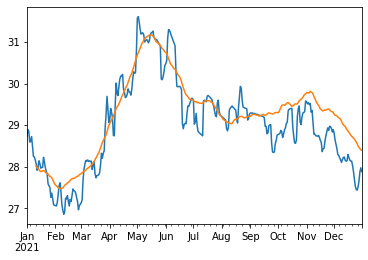

In [26]:
df['SST'].plot()
df['90percentile'].plot()